In [11]:
'''
STATISTICS. FINAL PROJECT
TITLE: Seed viability prediction
DATE 1/8/2018

STUDENT: Tamara Vasylenko
'''

In [1]:
import os
from IPython.display import Image
from IPython.core.display import HTML 

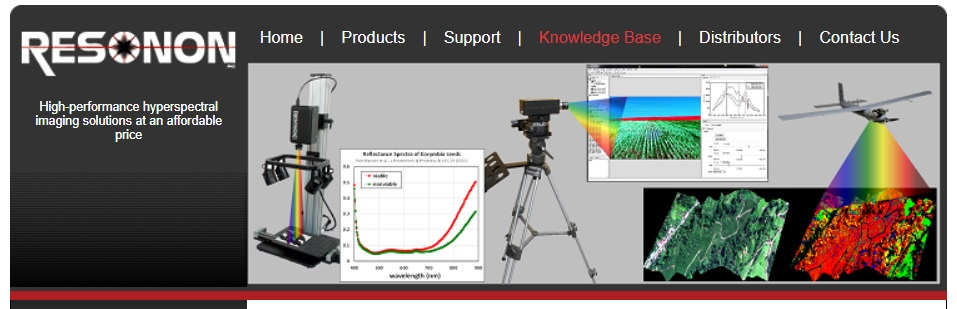

In [10]:
dir_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'img')
img_222 = os.path.join(dir_path, '222.jpg')
Image(filename = img_222, width=700, height=500)

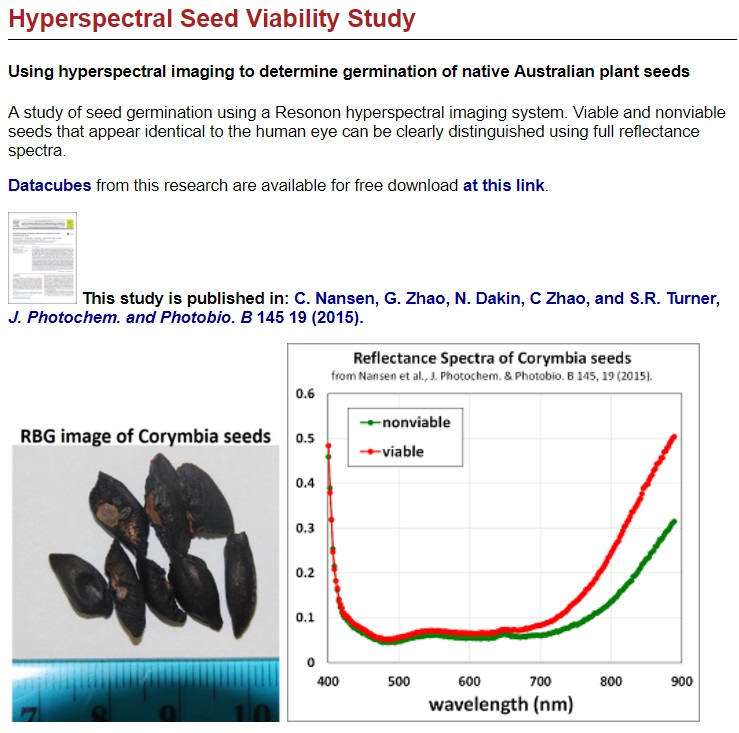

In [13]:
img_333 = os.path.join(dir_path, '333.jpg')
Image(filename = img_333, width=500, height=500)

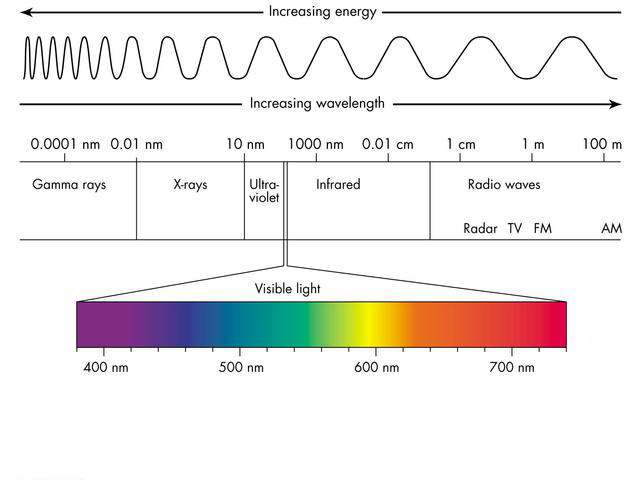

In [15]:
img_444 = os.path.join(dir_path, '444.jpg')
Image(filename = img_444, width=500, height=500)

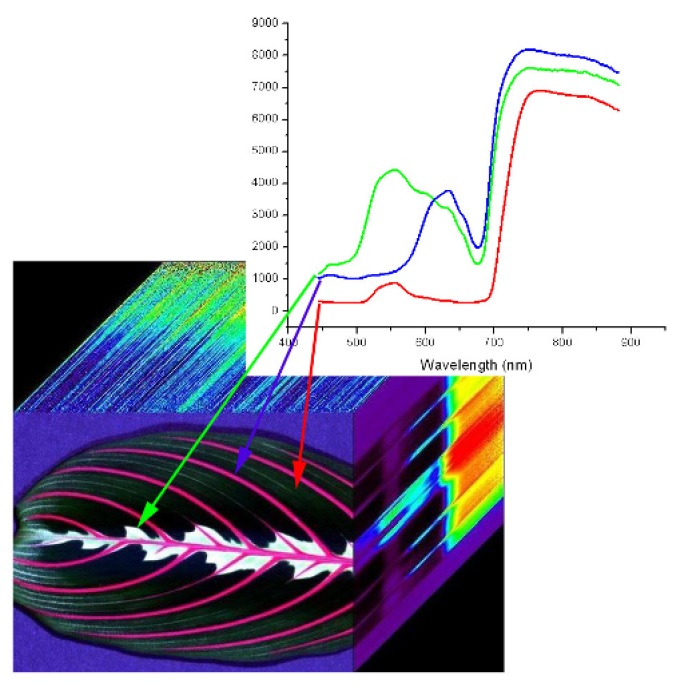

In [14]:
img_111 = os.path.join(dir_path, '111.jpg')
Image(filename = img_111, width=500, height=500)

In [16]:
'''
TITLE: Seed viability prediction
PLAN:
    Download images
    Normalize images
    Flatten images from 2D array into 1D array
    Select ROI:
        PCA
        K-means clustering
    SVM for classification
'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
import spectral.io.envi as envi
import glob

# Data source: https://downloads.resonon.com/categories/1/

dir_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'seed')
imgs_path = os.path.join(dir_path, '*.bil')
hdrs_path = os.path.join(dir_path, '*.bil.hdr')

imgs = []
for (i, h) in zip(glob.glob(imgs_path), glob.glob(hdrs_path)):
    imgs.append(h)
    imgs.append(i)

In [3]:
list(enumerate(imgs))

[(0, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Acacia_nonviable_day50.bil.hdr'),
 (1, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Acacia_nonviable_day50.bil'),
 (2, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Acacia_viable_day0.bil.hdr'),
 (3, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Acacia_viable_day0.bil'),
 (4, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Banksia_nonviable_day50.bil.hdr'),
 (5, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Banksia_nonviable_day50.bil'),
 (6, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Banksia_viable_day0.bil.hdr'),
 (7, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Banksia_viable_day0.bil'),
 (8,
  'C:\\Users\\user\\Desktop\\CLASS\\seed\\Corymbia_nonviable_day50.bil.hdr'),
 (9, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Corymbia_nonviable_day50.bil'),
 (10, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Corymbia_viable_day0.bil.hdr'),
 (11, 'C:\\Users\\user\\Desktop\\CLASS\\seed\\Corymbia_viable_day0.bil')]

In [4]:
# Read Acacia cowleana Tate seed images

In [5]:
from spectral import *

img_nonviable = envi.open(imgs[0], imgs[1])
img_viable = envi.open(imgs[2], imgs[3])

In [6]:
img_viable

	Data Source:   'C:\Users\user\Desktop\CLASS\seed\Acacia_viable_day0.bil'
	# Rows:            200
	# Samples:         640
	# Bands:           240
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32

In [7]:
img_viable.shape

(200, 640, 240)

In [8]:
# transform into list of 240 ndarrays

trans_viable = []
for i in range(240):
    trans_viable.append(img_viable.read_band(i))
trans_viable = np.asarray(trans_viable)
trans_viable = np.nan_to_num(trans_viable)

trans_nonviable = []
for i in range(240):
    trans_nonviable.append(img_nonviable.read_band(i))
trans_nonviable = np.asarray(trans_nonviable)
trans_nonviable = np.nan_to_num(trans_nonviable)
    
len(trans_viable), type(trans_viable)

(240, numpy.ndarray)

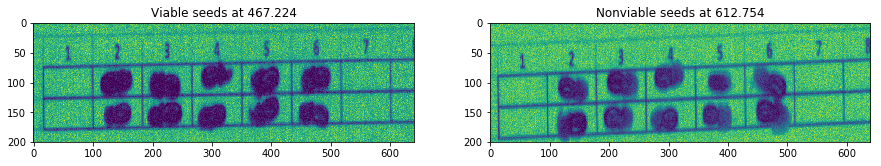

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].imshow(trans_viable[36]) #cmap='gray'
ax[0].set_title('Viable seeds at 467.224')

ax[1].imshow(trans_nonviable[106])
ax[1].set_title('Nonviable seeds at 612.754')

In [10]:
# Normalize pixel values in range [0, 1]

from skimage import exposure

def normalize_im(im):
    im_norm = (im - im.min()) / (im.max() - im.min())
    return im_norm

def normalize_imgs(imgs):
    n_imgs = []
    for i in range(len(imgs)):
        n_imgs.append(normalize_im(imgs[i]))   
    n_imgs = np.asarray(n_imgs)
    return n_imgs

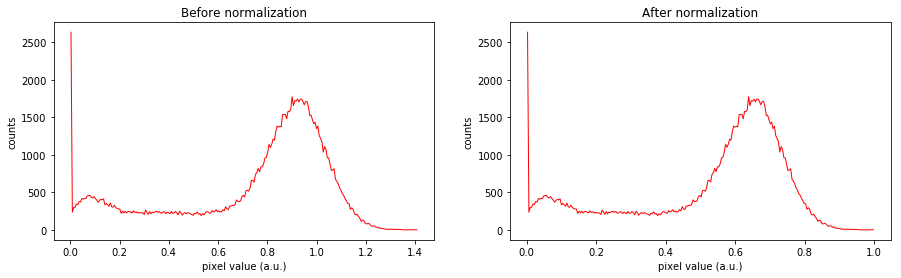

In [11]:
norm_viable = normalize_imgs(trans_viable)
norm_nonviable = normalize_imgs(trans_nonviable)

# DEMO
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

hist, bins = exposure.histogram(trans_viable[36])
ax[0].plot(bins, hist, linewidth=1, color='red')
ax[0].set_xlabel('pixel value (a.u.)')
ax[0].set_ylabel('counts')
ax[0].set_title('Before normalization')

hist, bins = exposure.histogram(norm_viable[36])
ax[1].plot(bins, hist, linewidth=1, color='red')
ax[1].set_xlabel('pixel value (a.u.)')
ax[1].set_ylabel('counts')
ax[1].set_title('After normalization')

In [12]:
# Transform each band image from 2D array into 1D array

def flatten_imgs(imgs):
    f_imgs = []
    for i in range(len(imgs)):
        f_imgs.append(imgs[i].flatten())  
    f_imgs = np.asarray(f_imgs) 
    return f_imgs

flat_viable = flatten_imgs(norm_viable)          # 240 horizontal arrays
flat_nonviable = flatten_imgs(norm_nonviable)    # 240 horizontal arrays

flat_viable.shape

(240, 128000)

In [13]:
raw_viable = np.transpose(flat_viable)
raw_nonviable = np.transpose(flat_nonviable)
raw_viable.shape

(128000, 240)

In [14]:
wave_int = [392.38, 394.459, 396.538, 398.617, 400.696, 402.775, 404.854, 406.933, 409.012, 411.091, 413.17, 415.249, 
            417.328, 419.407, 421.486, 423.565, 425.644, 427.723, 429.802, 431.881, 433.96, 436.039, 438.118, 440.197, 
            442.276, 444.355, 446.434, 448.513, 450.592, 452.671, 454.75, 456.829, 458.908, 460.987, 463.066, 465.145, 
            467.224, 469.303, 471.382, 473.461, 475.54, 477.619, 479.698, 481.777, 483.856, 485.935, 488.014, 490.093, 
            492.172, 494.251, 496.33, 498.409, 500.488, 502.567, 504.646, 506.725, 508.804, 510.883, 512.962, 515.041, 
            517.12, 519.199, 521.278, 523.357, 525.436, 527.515, 529.594, 531.673, 533.752, 535.831, 537.91, 539.989, 
            542.068, 544.147, 546.226, 548.305, 550.384, 552.463, 554.542, 556.621, 558.7, 560.779, 562.858, 564.937, 
            567.016, 569.095, 571.174, 573.253, 575.332, 577.411, 579.49, 581.569, 583.648, 585.727, 587.806, 589.885, 
            591.964, 594.043, 596.122, 598.201, 600.28, 602.359, 604.438, 606.517, 608.596, 610.675, 612.754, 614.833, 
            616.912, 618.991, 621.07, 623.149, 625.228, 627.307, 629.386, 631.465, 633.544, 635.623, 637.702, 639.781, 
            641.86, 643.939, 646.018, 648.097, 650.176, 652.255, 654.334, 656.413, 658.492, 660.571, 662.65, 664.729, 
            666.808, 668.887, 670.966, 673.045, 675.124, 677.203, 679.282, 681.361, 683.44, 685.519, 687.598, 689.677, 
            691.756, 693.835, 695.914, 697.993, 700.072, 702.151, 704.23, 706.309, 708.388, 710.467, 712.546, 714.625, 
            716.704, 718.783, 720.862, 722.941, 725.02, 727.099, 729.178, 731.257, 733.336, 735.415, 737.494, 739.573, 
            741.652, 743.731, 745.81, 747.889, 749.968, 752.047, 754.126, 756.205, 758.284, 760.363, 762.442, 764.521, 
            766.6, 768.679, 770.758, 772.837, 774.916, 776.995, 779.074, 781.153, 783.232, 785.311, 787.39, 789.469, 
            791.548, 793.627, 795.706, 797.785, 799.864, 801.943, 804.022, 806.101, 808.18, 810.259, 812.338, 814.417, 
            816.496, 818.575, 820.654, 822.733, 824.812, 826.891, 828.97, 831.049, 833.128, 835.207, 837.286, 839.365, 
            841.444, 843.523, 845.602, 847.681, 849.76, 851.839, 853.918, 855.997, 858.076, 860.155, 862.234, 864.313, 
            866.392, 868.471, 870.55, 872.629, 874.708, 876.787, 878.866, 880.945, 883.024, 885.103, 887.182, 889.261]

In [15]:
wave_str = list(map(str, wave_int))

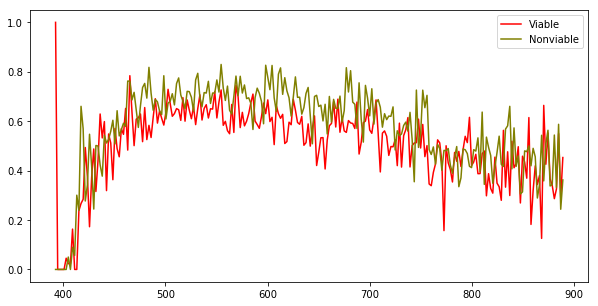

In [16]:
# 11700th pixel spectra as an example

pixel_viable = raw_viable[11700, :]
pixel_nonviable = raw_nonviable[11700, :]

plt.figure(figsize=(10, 5))
plt.plot(wave_int, pixel_viable, 'red')  
plt.plot(wave_int, pixel_nonviable, 'olive') 
plt.legend(('Viable', 'Nonviable'))
plt.show()

In [17]:
# Reduce dimensionality with PCA

from sklearn.decomposition import PCA

def pca_transform(X, n, whiten=True):
    if whiten:
        pca = PCA(n_components=n, whiten=True).fit(X)  
    else:
        pca = PCA(n_components=n).fit(X)
    projected = pca.transform(X)
    return pca, projected

pca1, pca_viable = pca_transform(raw_viable, 3)  # whiten=False
pca2, pca_nonviable = pca_transform(raw_nonviable, 3)

print(raw_viable.shape)
print(pca_viable.shape)
print(pca1.explained_variance_ratio_)   # viable
print(pca2.explained_variance_ratio_)   # non-viable

(128000, 240)
(128000, 3)
[ 0.78918522  0.01821774  0.00509006]
[ 0.77966712  0.01389151  0.00316005]


In [18]:
# Select ROI (region of interest) using K-means clustering

In [19]:
from sklearn.cluster import KMeans

def kmeans_predict(data, n):
    km = KMeans(n_clusters=n).fit(data)
    return km

In [20]:
def roi_from_kmeans(km, data):
    idx = np.argsort(km.cluster_centers_.sum(axis=1))     
    lut = idx[-1]
    print(idx, 'dont zero at position', lut)
    c_data = np.copy(data)
    for i in idx:
        if not i == lut:
            c_data[np.where(km.labels_ == i)] = 0
    return c_data

In [21]:
def demo(segmented):
    l = []
    for i in range(segmented.shape[1]):
        l.append(segmented[:, i].reshape((200, 640)))
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

    ax[0].imshow(l[0], cmap='gray')  
    ax[1].imshow(l[0])
    # ax[2].imshow(l[2])

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# 2 clusters on transformed data
viable_kmeans2 = kmeans_predict(pca_viable, 2)
nonviable_kmeans2 = kmeans_predict(pca_nonviable, 2)

segmented2_viable = roi_from_kmeans(viable_kmeans2, pca_viable)
segmented2_nonviable = roi_from_kmeans(nonviable_kmeans2, pca_nonviable)

[0 1] dont zero at position 1
[0 1] dont zero at position 1


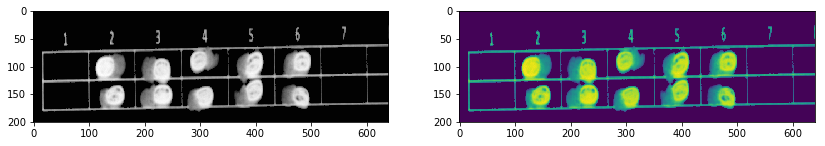

In [23]:
demo(segmented2_viable) # mask

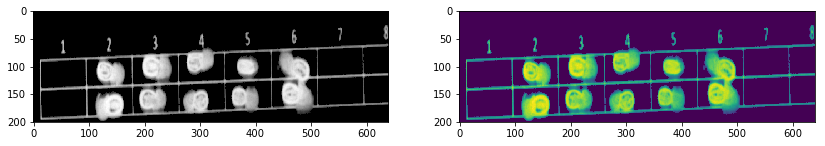

In [24]:
demo(segmented2_nonviable) #mask

In [25]:
# Crop original image & mask

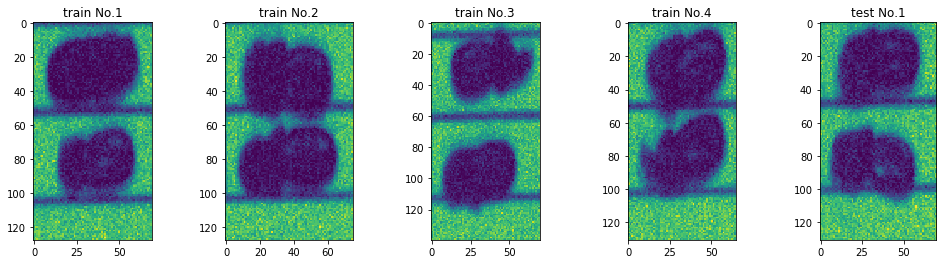

In [26]:
# Original image [viable]
# Split viable seed image into train (8) and test (2)

train_viable1 = []
for i in range(240):
    train_viable1.append(trans_viable[i][72:, 105:175])

train_viable2 = []
for i in range(240):
    train_viable2.append(trans_viable[i][72:, 185:260])

train_viable3 = []
for i in range(240):
    train_viable3.append(trans_viable[i][60:, 270:340])

train_viable4 = []
for i in range(240):
    train_viable4.append(trans_viable[i][69:, 355:420])

test_viable1 = []
for i in range(240):
    test_viable1.append(trans_viable[i][69:, 440:510])
    
    
# Plot example 36th band
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(17, 4))

ax[0].imshow(train_viable1[36]) 
ax[0].set_title('train No.1')

ax[1].imshow(train_viable2[36])
ax[1].set_title('train No.2')

ax[2].imshow(train_viable3[36])
ax[2].set_title('train No.3')

ax[3].imshow(train_viable4[36])
ax[3].set_title('train No.4')

ax[4].imshow(test_viable1[36])
ax[4].set_title('test No.1')

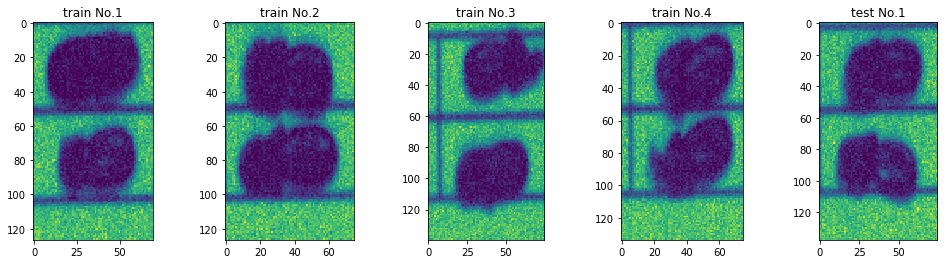

In [27]:
# Original image [nonviable]
# Split viable seed image into train (8) and test (2)

train_nonviable1 = []
for i in range(240):
    train_nonviable1.append(trans_viable[i][73:, 105:175])

train_nonviable2 = []
for i in range(240):
    train_nonviable2.append(trans_viable[i][73:, 185:260])

train_nonviable3 = []
for i in range(240):
    train_nonviable3.append(trans_viable[i][60:, 260:335])

train_nonviable4 = []
for i in range(240):
    train_nonviable4.append(trans_viable[i][66:, 345:420])

test_nonviable1 = []
for i in range(240):
    test_nonviable1.append(trans_viable[i][62:, 435:510])
    
    
# Plot example 36th band
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(17, 4))

ax[0].imshow(train_nonviable1[36]) 
ax[0].set_title('train No.1')

ax[1].imshow(train_nonviable2[36])
ax[1].set_title('train No.2')

ax[2].imshow(train_nonviable3[36])
ax[2].set_title('train No.3')

ax[3].imshow(train_nonviable4[36])
ax[3].set_title('train No.4')

ax[4].imshow(test_nonviable1[36])
ax[4].set_title('test No.1')

In [28]:
l = []
for i in range(segmented2_viable.shape[1]):
    l.append(segmented2_viable[:, i].reshape((200, 640)))
    
l[0].shape

(200, 640)

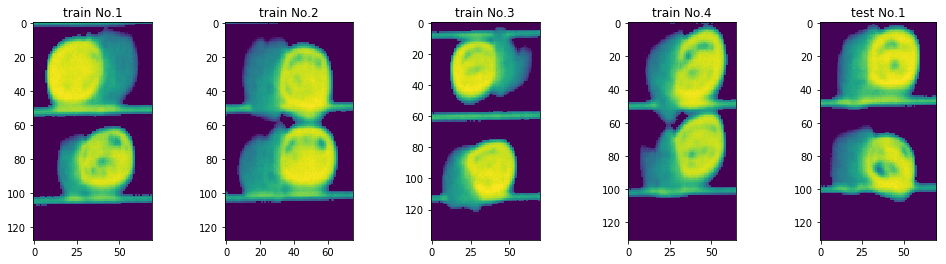

In [29]:
# Mask [viable]

train_mask_viable1 = l[0][72:, 105:175]
train_mask_viable2 = l[0][72:, 185:260]
train_mask_viable3 = l[0][60:, 270:340]
train_mask_viable4 = l[0][69:, 355:420]
test_mask_viable1 = l[0][69:, 440:510]

# Plot example 36th band
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(17, 4))

ax[0].imshow(train_mask_viable1) 
ax[0].set_title('train No.1')

ax[1].imshow(train_mask_viable2)
ax[1].set_title('train No.2')

ax[2].imshow(train_mask_viable3)
ax[2].set_title('train No.3')

ax[3].imshow(train_mask_viable4)
ax[3].set_title('train No.4')

ax[4].imshow(test_mask_viable1)
ax[4].set_title('test No.1')

In [30]:
l = []
for i in range(segmented2_viable.shape[1]):
    l.append(segmented2_nonviable[:, i].reshape((200, 640)))
    
l[0].shape

(200, 640)

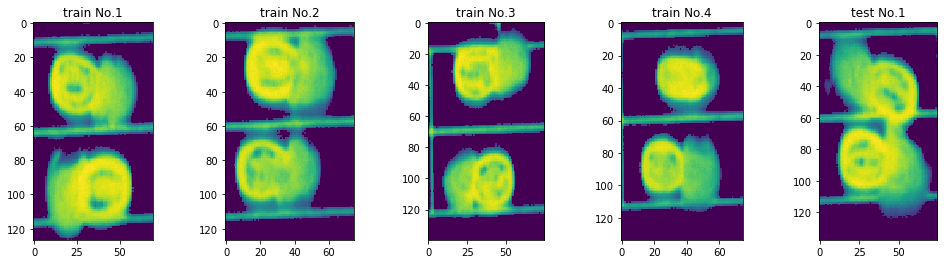

In [31]:
# Mask [nonviable]

train_mask_nonviable1 = l[0][73:, 105:175]
train_mask_nonviable2 = l[0][73:, 185:260]
train_mask_nonviable3 = l[0][60:, 260:335]
train_mask_nonviable4 = l[0][66:, 345:420]
test_mask_nonviable1 = l[0][62:, 435:510]

# Plot example 36th band
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(17, 4))

ax[0].imshow(train_mask_nonviable1) 
ax[0].set_title('train No.1')

ax[1].imshow(train_mask_nonviable2)
ax[1].set_title('train No.2')

ax[2].imshow(train_mask_nonviable3)
ax[2].set_title('train No.3')

ax[3].imshow(train_mask_nonviable4)
ax[3].set_title('train No.4')

ax[4].imshow(test_mask_nonviable1)
ax[4].set_title('test No.1')

In [71]:
# No.1 train for viable
mask = np.invert(train_mask_viable1.astype(bool))

spectra_train_viable1 = []
for i in range(len(train_viable1)):
    c = np.ma.array(train_viable1[i], mask = mask)  
    spectra_train_viable1.append(np.mean(c))
 
# spectra_train_viable1 - train instance for viable class (240 length vector)
len(spectra_train_viable1)

240

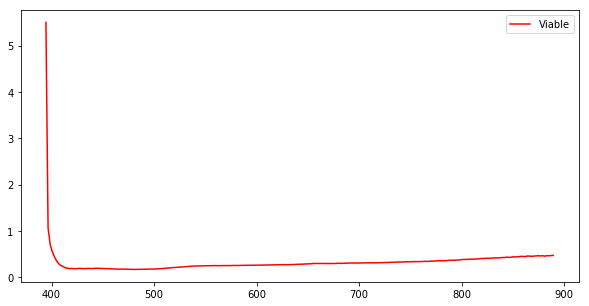

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_viable1, 'red')  
plt.legend(('Viable',))
plt.show()

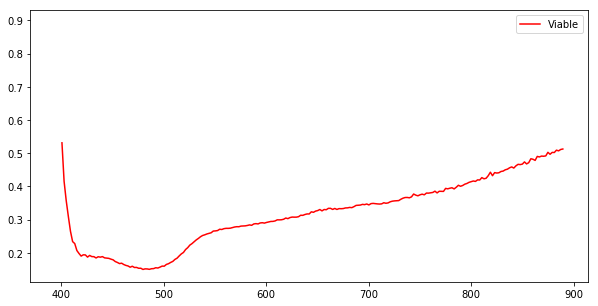

In [79]:
# No.2 train for viable
mask = np.invert(train_mask_viable2.astype(bool))

spectra_train_viable2 = []
for i in range(len(train_viable2)):
    c = np.ma.array(train_viable2[i], mask = mask)  
    spectra_train_viable2.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_viable2, 'red')  
plt.legend(('Viable',))
plt.show()

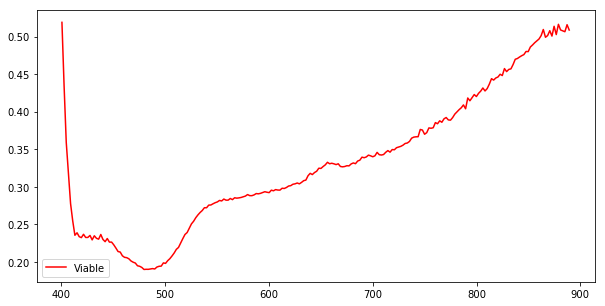

In [80]:
# No.3 train for viable
mask = np.invert(train_mask_viable3.astype(bool))

spectra_train_viable3 = []
for i in range(len(train_viable3)):
    c = np.ma.array(train_viable3[i], mask = mask)  
    spectra_train_viable3.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_viable3, 'red')
plt.legend(('Viable',))
plt.show()

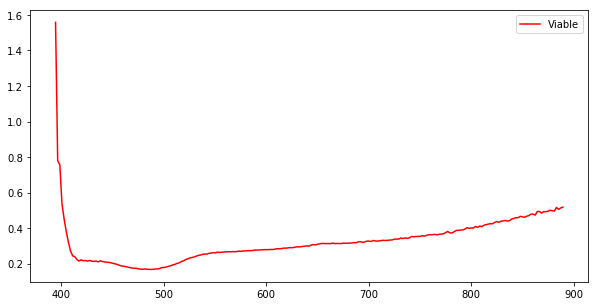

In [81]:
# No.4 train for viable
mask = np.invert(train_mask_viable4.astype(bool))

spectra_train_viable4 = []
for i in range(len(train_viable4)):
    c = np.ma.array(train_viable4[i], mask = mask)  
    spectra_train_viable4.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_viable4, 'red')
plt.legend(('Viable',))
plt.show()

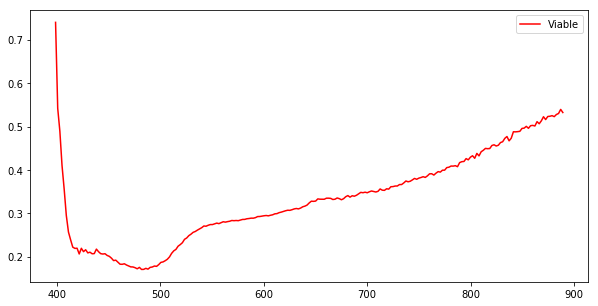

In [82]:
# No.1 test for viable
mask = np.invert(test_mask_viable1.astype(bool))

spectra_test_viable1 = []
for i in range(len(test_viable1)):
    c = np.ma.array(test_viable1[i], mask = mask)  
    spectra_test_viable1.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_test_viable1, 'red') 
plt.legend(('Viable',))
plt.show()

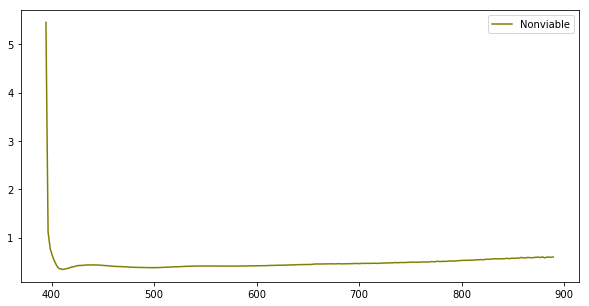

In [83]:
# No.1 train for nonviable
mask = np.invert(train_mask_nonviable1.astype(bool))

spectra_train_nonviable1 = []
for i in range(len(train_nonviable1)):
    c = np.ma.array(train_nonviable1[i], mask = mask)  
    spectra_train_nonviable1.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_nonviable1, 'olive')  
plt.legend(('Nonviable',))
plt.show()

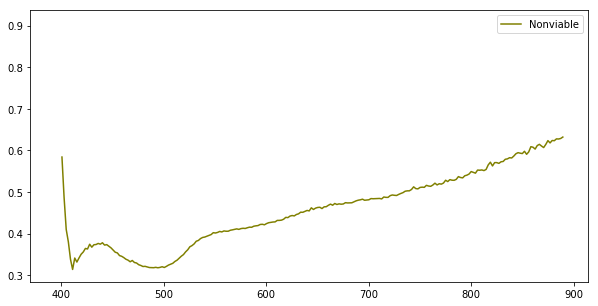

In [84]:
# No.2 train for nonviable
mask = np.invert(train_mask_nonviable2.astype(bool))

spectra_train_nonviable2 = []
for i in range(len(train_nonviable2)):
    c = np.ma.array(train_nonviable2[i], mask = mask)  
    spectra_train_nonviable2.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_nonviable2, 'olive')  
plt.legend(('Nonviable',))
plt.show()

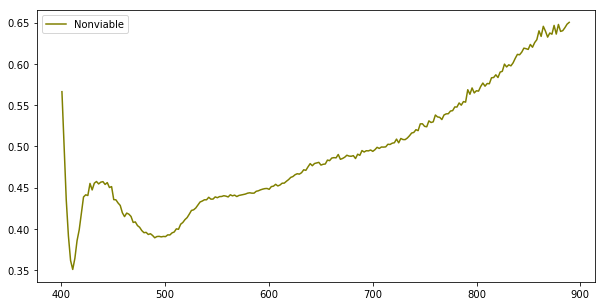

In [85]:
# No.3 train for nonviable
mask = np.invert(train_mask_nonviable3.astype(bool))

spectra_train_nonviable3 = []
for i in range(len(train_nonviable3)):
    c = np.ma.array(train_nonviable3[i], mask = mask)  
    spectra_train_nonviable3.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_nonviable3, 'olive')  
plt.legend(('Nonviable',))
plt.show()

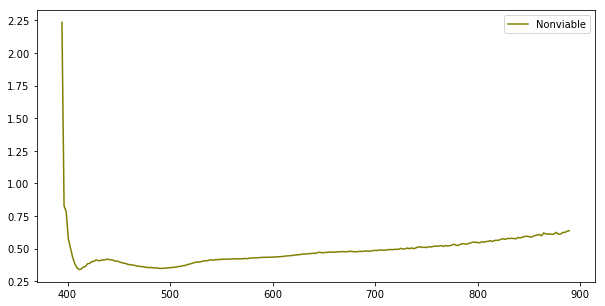

In [86]:
# No.4 train for nonviable
mask = np.invert(train_mask_nonviable4.astype(bool))

spectra_train_nonviable4 = []
for i in range(len(train_nonviable4)):
    c = np.ma.array(train_nonviable4[i], mask = mask)  
    spectra_train_nonviable4.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_train_nonviable4, 'olive')  
plt.legend(('Nonviable',))
plt.show()

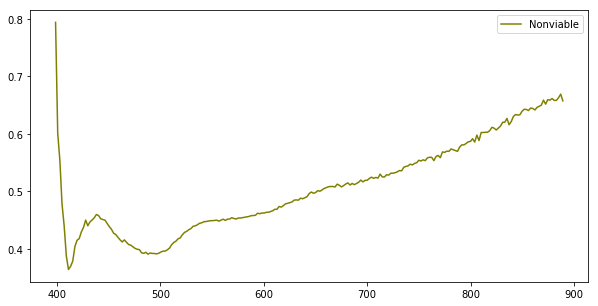

In [87]:
# No.1 test for nonviable
mask = np.invert(test_mask_nonviable1.astype(bool))

spectra_test_nonviable1 = []
for i in range(len(test_nonviable1)):
    c = np.ma.array(test_nonviable1[i], mask = mask)  
    spectra_test_nonviable1.append(np.mean(c))
    
plt.figure(figsize=(10, 5))
plt.plot(wave_int, spectra_test_nonviable1, 'olive')  
plt.legend(('Nonviable',))
plt.show()

In [151]:
# add test to remove inf and nan values
X = np.array([spectra_train_viable1, spectra_train_viable2, spectra_train_viable3, spectra_train_viable4, 
             spectra_train_nonviable1, spectra_train_nonviable2, spectra_train_nonviable3, spectra_train_nonviable4,
             spectra_test_viable1, spectra_test_nonviable1])
X

array([[        inf,  5.50493974,  1.07116244, ...,  0.46508193,
         0.46962642,  0.47334681],
       [        inf,  0.89421616,         inf, ...,  0.5072473 ,
         0.51137207,  0.51281637],
       [        inf,         inf,         inf, ...,  0.50648747,
         0.51581536,  0.50873587],
       ..., 
       [        inf,  2.23532023,  0.82712606, ...,  0.62425495,
         0.63322123,  0.63754308],
       [        inf,         inf,         inf, ...,  0.52997447,
         0.5394211 ,  0.53220474],
       [        inf,         inf,         inf, ...,  0.66281631,
         0.66904277,  0.65734691]])

In [152]:
X.shape

(10, 240)

In [153]:
X = X[:,~np.any(np.isinf(X), axis=0)]

In [154]:
X = X[:,~np.any(np.isnan(X), axis=0)]

In [155]:
X.shape

(10, 236)

In [156]:
spectra_test_viable1 = X[8].tolist()
spectra_test_nonviable1 = X[9].tolist()

X = np.delete(X, 9, 0)
X = np.delete(X, 8, 0)
X.shape

(8, 236)

In [157]:
y = np.array([1, 1, 1, 1, 0, 0, 0, 0])

In [158]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [159]:
print(clf.predict([spectra_test_viable1]))

[1]


In [160]:
print(clf.predict([spectra_test_nonviable1]))

[0]


In [ ]:
# THANK YOU FOR YOUR ATTENTION!